Found 1484 files belonging to 2 classes.
Using 1188 files for training.
Found 1484 files belonging to 2 classes.
Using 296 files for validation.
Found 372 files belonging to 2 classes.
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6175 - loss: 0.6942 - val_accuracy: 0.8041 - val_loss: 0.4224
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8017 - loss: 0.4180 - val_accuracy: 0.8243 - val_loss: 0.3990
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8119 - loss: 0.3835 - val_accuracy: 0.8243 - val_loss: 0.3955
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8463 - loss: 0.3515 - val_accuracy: 0.8378 - val_loss: 0.3347
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8713 - loss: 0.3129 - val_accuracy: 0.7872 - val_loss: 0.4124
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8841 - loss: 0.2919 - val_accuracy: 0.8277 - val_loss: 0.3708
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accur

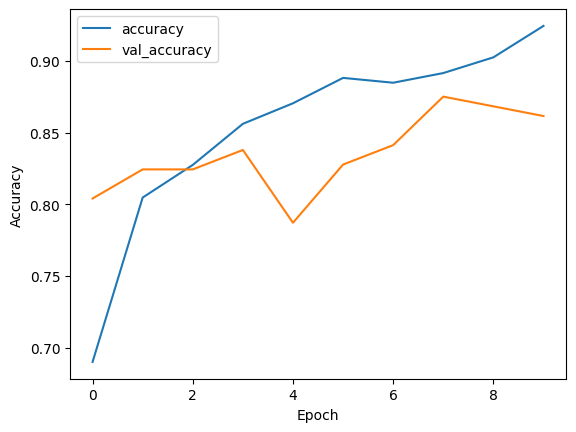

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


train_dir = '/content/drive/MyDrive/dataset/train'
test_dir = '/content/drive/MyDrive/dataset/test'

batch_size = 32
img_size = (224, 224)


train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)


base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[early_stopping])


test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


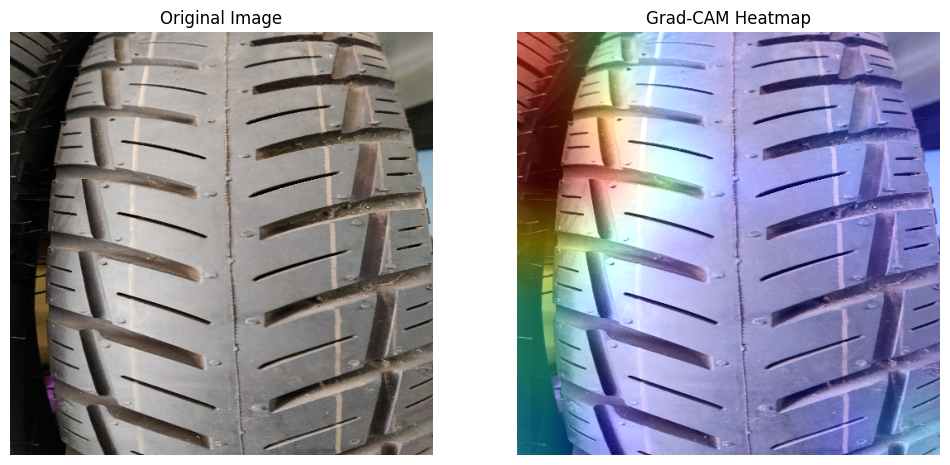

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]


    grads = tape.gradient(class_channel, conv_outputs)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def display_gradcam(img_path, heatmap, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.colormaps["jet"]


    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[0], img.shape[1]))

    superimposed_img = jet_heatmap * alpha + img / 255.0


    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(img / 255.0)
    plt.axis('off')
    plt.title('Original Image')


    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM Heatmap')

    plt.show()

img_path = '/content/drive/MyDrive/dataset/test/good/good (127)_be8a20e278cb4b408cde914cd2f291be.jpg'


img_size = (224, 224)
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)




last_conv_layer_name = 'Conv_1'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


display_gradcam(img_path, heatmap)


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


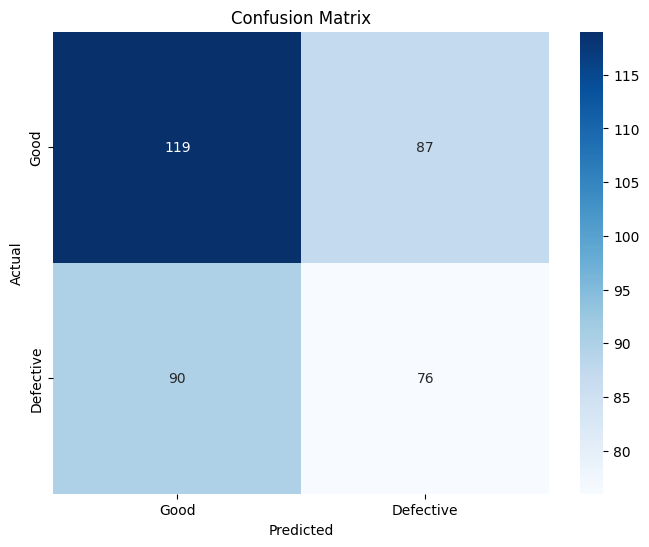

              precision    recall  f1-score   support

        Good       0.57      0.58      0.57       206
   Defective       0.47      0.46      0.46       166

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.52       372
weighted avg       0.52      0.52      0.52       372

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The image is predicted as: Good tyre


In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def evaluate_model(model, test_dataset):
    true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predicted_probs = model.predict(test_dataset)
    predicted_labels = (predicted_probs > 0.5).astype(int).reshape(-1)
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm, true_labels, predicted_labels

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def predict_image_class(img_path, model):
    img_size = (224, 224)
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    prediction = model.predict(img_array)[0][0]
    return "Good" if prediction < 0.5 else "Defective", prediction

cm, true_labels, predicted_labels = evaluate_model(model, test_dataset)
class_names = ['Good', 'Defective']
plot_confusion_matrix(cm, class_names)


print(classification_report(true_labels, predicted_labels, target_names=class_names))
img_path = '/content/drive/MyDrive/dataset/test/good/good (127)_be8a20e278cb4b408cde914cd2f291be.jpg'
predicted_class, probability = predict_image_class(img_path, model)
print(f"The image is predicted as: {predicted_class} tyre")
